IMPORTAR LIBRERIAS

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

Cargar datos desde el csv

In [56]:
data = pd.read_csv('datos_timeserie.csv', sep=';')
data

,fecha,monto de compra
0,12/07/2022,-50
1,1/04/2020,0
2,20/07/2022,100
3,24/11/2020,0
4,13/03/2021,1000000
...,...,...
8722,28/04/2024,1000000
8723,19/06/2021,300
8724,31/12/2021,100
8725,8/09/2024,1000000


Verificación de tipo de datos y estadística básica

In [57]:
data.dtypes

fecha              object
monto de compra     int64
dtype: object

In [58]:
print('\nEstadística de datos en el DataFrame:')  
data.describe()


Estadística de datos en el DataFrame:


,monto de compra
count,8727.000000
mean,142653.861579
std,348605.805477
min,-50.000000
25%,0.000000
50%,200.000000
75%,5000.000000
max,1000000.000000


Verificación de datos nulos/faltantes

In [59]:
print('Datos nulos en el DataFrame:')
data.isnull().sum()

Datos nulos en el DataFrame:


fecha              4
monto de compra    0
dtype: int64

eliminar valores nulos de fecha

In [60]:
data = data.dropna(subset=['fecha'])

In [61]:
print('Datos nulos en el DataFrame:')
data.isnull().sum()

Datos nulos en el DataFrame:


fecha              0
monto de compra    0
dtype: int64

Mover el índice 'Fecha' a una columna y renombrarla a 'Date'

In [62]:
data.rename(columns={'fecha': 'Date'}, inplace=True)
data

C:\Users\damak\AppData\Local\Temp\ipykernel_19556\2415425798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'fecha': 'Date'}, inplace=True)


,Date,monto de compra
0,12/07/2022,-50
1,1/04/2020,0
2,20/07/2022,100
3,24/11/2020,0
4,13/03/2021,1000000
...,...,...
8722,28/04/2024,1000000
8723,19/06/2021,300
8724,31/12/2021,100
8725,8/09/2024,1000000


In [63]:
data.rename(columns={'monto de compra':'Monto'}, inplace=True)
data

C:\Users\damak\AppData\Local\Temp\ipykernel_19556\2893497549.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'monto de compra':'Monto'}, inplace=True)


,Date,Monto
0,12/07/2022,-50
1,1/04/2020,0
2,20/07/2022,100
3,24/11/2020,0
4,13/03/2021,1000000
...,...,...
8722,28/04/2024,1000000
8723,19/06/2021,300
8724,31/12/2021,100
8725,8/09/2024,1000000


Verificar que algunas fechas no tienen formato para pandas

In [64]:
invalid_dates = data[~pd.to_datetime(data['Date'], errors='coerce').notna()]
print(invalid_dates)

            Date    Monto
2     20/07/2022      100
3     24/11/2020        0
4     13/03/2021  1000000
6     25/02/2023      100
7     17/11/2024        0
...          ...      ...
8720  14/05/2024      300
8721  17/08/2022     5000
8722  28/04/2024  1000000
8723  19/06/2021      300
8724  31/12/2021      100

[5376 rows x 2 columns]


In [65]:
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')

C:\Users\damak\AppData\Local\Temp\ipykernel_19556\3589003215.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')


In [66]:
print(data[data['Date'].isna()])

Empty DataFrame
Columns: [Date, Monto]
Index: []


Convertir la columna Date a tipo datetime y establecer la columna Date como índice

In [67]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data

C:\Users\damak\AppData\Local\Temp\ipykernel_19556\3346301651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


,Monto
Date,
2022-07-12,-50
2020-04-01,0
2022-07-20,100
2020-11-24,0
2021-03-13,1000000
...,...
2024-04-28,1000000
2021-06-19,300
2021-12-31,100


VISUALIZACIÓN DE LOS VALORES INICIALES

Se realiza una visualización preliminar para determinar el comportamiento de los datos en el tiempo.

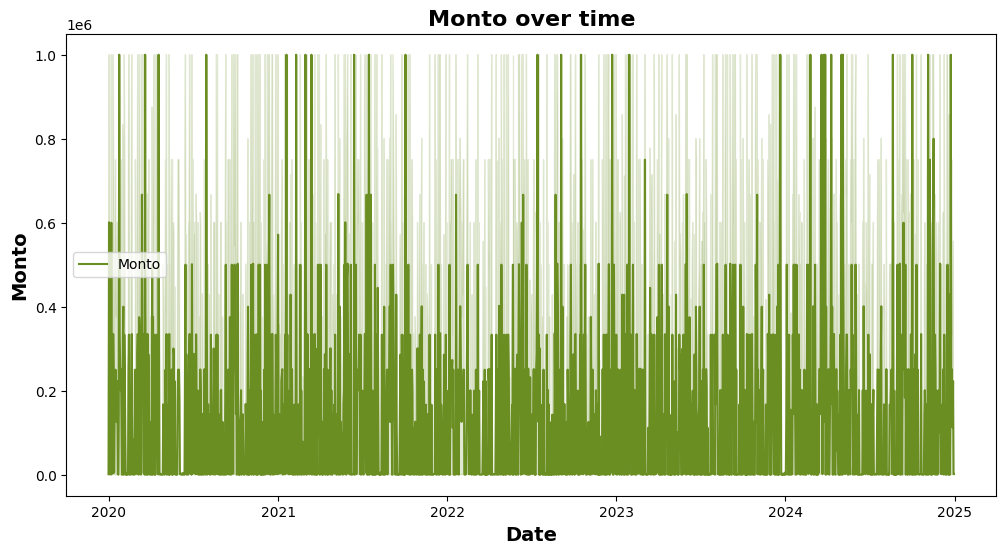

In [68]:
plt.figure(figsize=(12, 6), dpi=100)
sns.lineplot(data=data, x='Date', y='Monto', label='Monto', color='olivedrab')

plt.title('Monto over time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Monto', fontsize=14, fontweight='bold')
plt.legend()

plt.show()

agrupar por mes dada la gran cantidad de datos que presento

C:\Users\damak\AppData\Local\Temp\ipykernel_19556\1004690117.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data.resample('M').sum()


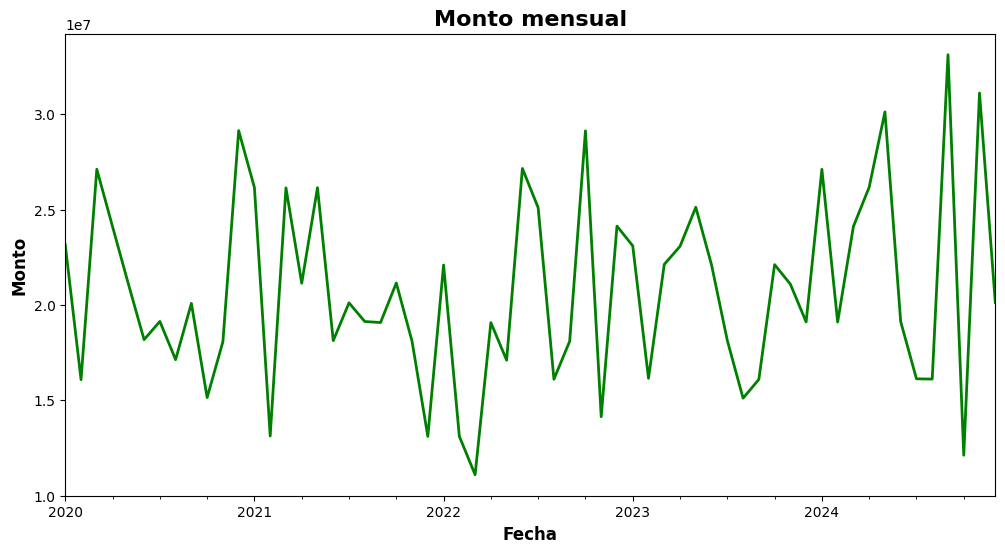

In [69]:

monthly_data = data.resample('M').sum()


monthly_data['Monto'].plot(figsize=(12,6), color="green", linewidth=2)
plt.title("Monto mensual", fontsize=16, fontweight="bold")
plt.xlabel("Fecha", fontsize=12, fontweight="bold")
plt.ylabel("Monto", fontsize=12, fontweight="bold")
plt.show()

Copia Dataset

In [70]:
df = monthly_data.copy()

## Descomposición Estacional
Descompone una serie temporal en sus componentes:

Tendencia (movimiento a largo plazo).

Estacionalidad (patrones que se repiten en intervalos fijos).

Residual (ruido o variabilidad no explicada).

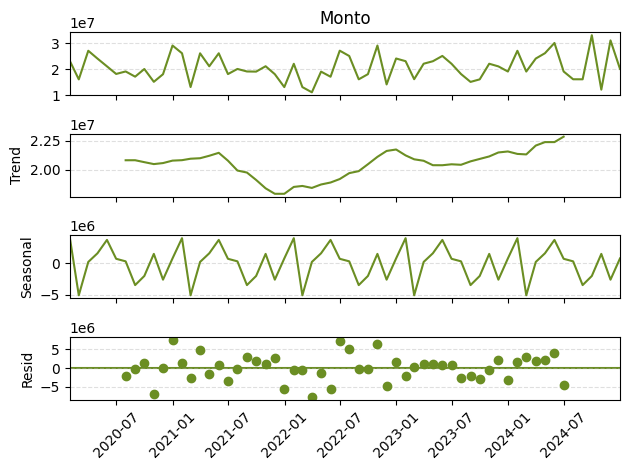

In [71]:
descompose_data = seasonal_decompose(df['Monto'], model='additive', period=12)
fig = descompose_data.plot()
axes = fig.get_axes()

wanted_color = 'olivedrab'

for ax in axes:
    for line in ax.get_lines():
        line.set_color(wanted_color)
        line.set_linewidth(1.5)


    for coll in ax.collections:
        coll.set_color(wanted_color)


for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.4)


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

La serie no muestra una estacionalidad clara (patrón repetitivo cada año o trimestre).

Lo que se observa es mucha variabilidad aleatoria (ruido) con picos fuertes.

Se realizará con un modelo aditivo todo pero toca mejorar el ruido de los datos

## Dividir los datos en set de entrenamiento y de prueba

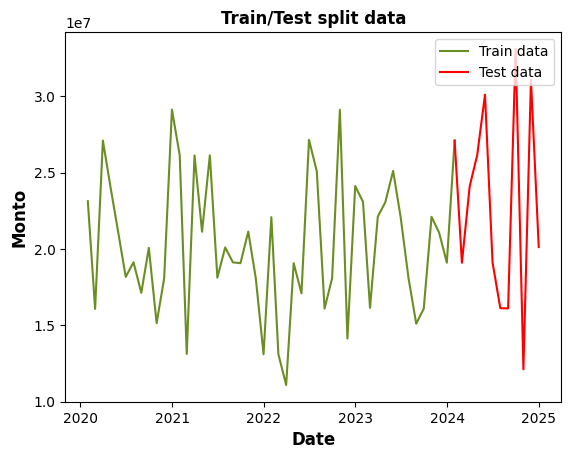

In [72]:
train_size = int(len(df) * 0.8)

train_data, test_data = df.iloc[:train_size + 1], df.iloc[train_size:]

plt.plot(train_data, color = 'olivedrab', label = 'Train data')
plt.plot(test_data, color = 'red', label ='Test data')
plt.ylabel('Monto', fontsize = 12, fontweight = 'bold')
plt.xlabel('Date', fontsize = 12, fontweight = 'bold')
plt.xticks(rotation = 0)
plt.legend(loc ='upper right')
plt.title('Train/Test split data', fontsize = 12, fontweight = 'bold')
plt.show()

MODELOS
Dada la estacionalidad de los datos se proponen usar cuatro modelos:

Holt–Winters (Triple Exponential Smoothing):
Método de suavizado exponencial que modela simultáneamente nivel, tendencia y estacionalidad; ideal para series con ciclo fijo y tendencia suave.

ARIMA (AutoRegressive Integrated Moving Average):
Combina autorregresión, diferenciación para estacionariedad y promedio móvil; apropiado cuando no hay estacionalidad fuerte o tras eliminarla manualmente.

SARIMAX (Seasonal ARIMA con Exógenas)
Extiende ARIMA incluyendo un componente estacional fijo (p,d,q)×(P,D,Q,s) y variables exógenas; recomendado para datos con estacionalidad clara y regresores adicionales.

## Holt-Winters Model

In [73]:
hw_model = ExponentialSmoothing(train_data['Monto'], trend = 'add', seasonal = 'add', seasonal_periods = 12)
hw_fit = hw_model.fit()
hw_pred = hw_fit.forecast(len(test_data))

hw_mse = mean_squared_error(test_data['Monto'], hw_pred)
hw_mae = mean_absolute_error(test_data['Monto'], hw_pred)
hw_rmse = np.sqrt(hw_mse)
hw_mape = mean_absolute_percentage_error(test_data['Monto'], hw_pred)

print(f'Holt-Winters Metrics: \nMSE = {hw_mse} \nMAE = {hw_mae} \nRMSE = {hw_rmse} \nMAPE = {hw_mape}')

Holt-Winters Metrics: 
MSE = 43801030955733.98 
MAE = 5244706.017881479 
RMSE = 6618234.731084565 
MAPE = 0.21377143558538292


## SARIMAX Model

In [74]:
sarimax_model = SARIMAX(train_data['Monto'], order=(0, 0, 1), seasonal_order=(1, 0, 0, 12))
sarimax_fit = sarimax_model.fit()
sarimax_pred = sarimax_fit.predict(start = len(train_data), end = (len(train_data) + len(test_data) - 1), typ ='levels')

sarimax_mse = mean_squared_error(test_data['Monto'], sarimax_pred)
sarimax_mae = mean_absolute_error(test_data['Monto'], sarimax_pred)
sarimax_rmse = np.sqrt(sarimax_mse)
sarimax_mape = mean_absolute_percentage_error(test_data['Monto'], sarimax_pred)

print(f'SARIMAX Metrics: \nMSE = {sarimax_mse} \nMAE = {sarimax_mae} \nRMSE = {sarimax_rmse} \nMAPE = {sarimax_mape}')

SARIMAX Metrics: 
MSE = 169814512416855.47 
MAE = 11557232.087625107 
RMSE = 13031289.74495063 
MAPE = 0.47478444585392304


c:\Estudio\prueba_tecnica_analista_datos_junior\.venv\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


## ARIMA MODEL

In [75]:
arima_model = ARIMA(train_data['Monto'], order=(1, 1, 0))
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(test_data))

arima_mse = mean_squared_error(test_data['Monto'], arima_pred)
arima_mae = mean_absolute_error(test_data['Monto'], arima_pred)
arima_rmse = np.sqrt(arima_mse)
arima_mape = mean_absolute_percentage_error(test_data['Monto'], arima_pred)

print(f'ARIMA Metrics: \nMSE = {arima_mse} \nMAE = {arima_mae} \nRMSE = {arima_rmse} \nMAPE = {arima_mape}')

ARIMA Metrics: 
MSE = 45767667908365.85 
MAE = 5954069.9234964205 
RMSE = 6765180.552532641 
MAPE = 0.3142911215670388


## PROPHET MODEL

In [76]:
from prophet import Prophet
prophet_data = df.reset_index().rename(columns={'Date': 'ds', 'Monto': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_data)
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='M')
forecast = prophet_model.predict(future)

prophet_pred = forecast['yhat'][-len(test_data):].values

prophet_mse = mean_squared_error(test_data['Monto'], prophet_pred)
prophet_mae = mean_absolute_error(test_data['Monto'], prophet_pred)
prophet_rmse = np.sqrt(prophet_mse)
prophet_mape = mean_absolute_percentage_error(test_data['Monto'], prophet_pred)


print(f'Prophet MSE: \nMSE = {prophet_mse} \nMAE = {prophet_mae} \nRMSE = {prophet_rmse} \nMAPE = {prophet_mape}')

23:24:34 - cmdstanpy - INFO - Chain [1] start processing
23:24:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet MSE: 
MSE = 27478422463344.535 
MAE = 4336627.590190796 
RMSE = 5241986.499729328 
MAPE = 0.20580438244393162


c:\Estudio\prueba_tecnica_analista_datos_junior\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


COMPARACIÓN DE LOS RESULTADOS

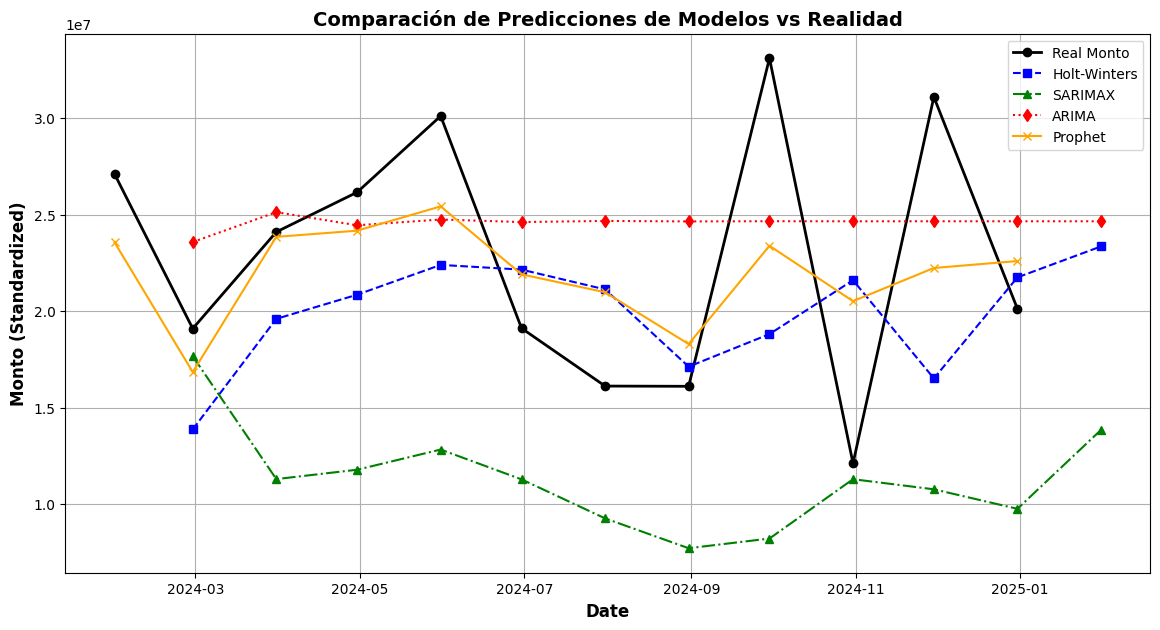

In [77]:
plt.figure(figsize=(14, 7), dpi=100)

plt.plot(test_data.index, test_data['Monto'], label='Real Monto', color='black', linewidth=2, marker='o')
plt.plot(hw_pred.index, hw_pred.values, label='Holt-Winters', color='blue', linestyle='--', marker='s')
plt.plot(sarimax_pred.index, sarimax_pred.values, label='SARIMAX', color='green', linestyle='-.', marker='^')
plt.plot(arima_pred.index, arima_pred.values, label='ARIMA', color='red', linestyle=':', marker='d')
plt.plot(test_data.index, prophet_pred, label='Prophet', color='orange', linestyle='-', marker='x')


plt.title('Comparación de Predicciones de Modelos vs Realidad', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Monto (Standardized)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

TABLA DE RESULTADOS

In [78]:
results = pd.DataFrame({
    'Model': ['Holt-Winters', 'SARIMAX', 'ARIMA', 'Prophet'],
    'MSE': [hw_mse, sarimax_mse, arima_mse, prophet_mse],
    'MAE': [hw_mae, sarimax_mae, arima_mae, prophet_mae],
    'RMSE': [hw_rmse, sarimax_rmse, arima_rmse, prophet_rmse],
    'MAPE': [hw_mape, sarimax_mape, arima_mape, prophet_mape]
})
print('\nTabla de Resultados:')
print(results)


Tabla de Resultados:
          Model           MSE           MAE          RMSE      MAPE
0  Holt-Winters  4.380103e+13  5.244706e+06  6.618235e+06  0.213771
1       SARIMAX  1.698145e+14  1.155723e+07  1.303129e+07  0.474784
2         ARIMA  4.576767e+13  5.954070e+06  6.765181e+06  0.314291
3       Prophet  2.747842e+13  4.336628e+06  5.241986e+06  0.205804


Dado que nuestro objetivo es optimizar la precisión del pronóstico en los próximos tres meses, se decide descartar ARIMA y SARIMAX y concentrarse en Holt–Winters y Prophet, que mostraron mejor ajuste a los patrones de la serie. Los resultados de la tabla muestran claramente que tanto Holt–Winters como Prophet presentan los menores errores de validación (MSE, MAE, RMSE, MAPE) en comparación con SARIMAX y ARIMA, lo que evidencia su mayor capacidad de captura de la dinámica de la serie. Aunque es evidencia de la falta de estacionalidad de los datos.

Forecasting de los próximos 3 meses

In [79]:
hw_pred_future = hw_fit.forecast(len(test_data) + 2)
hw_pred_future = hw_pred_future[-3:]

print(f'Pronóstico de los próximos 3 meses con el modelo Holt-Winters:\n{hw_pred_future}')

Pronóstico de los próximos 3 meses con el modelo Holt-Winters:
2025-01-31    2.336030e+07
2025-02-28    1.373812e+07
2025-03-31    1.946928e+07
Freq: ME, dtype: float64


In [80]:
prophet_future = prophet_model.make_future_dataframe(periods=3, freq='M')
prophet_forecast = prophet_model.predict(prophet_future)
prophet_pred_future = pd.Series(
    data=forecast['yhat'].tail(3).values,
    index=pd.to_datetime(forecast['ds'].tail(3))
)

print("Pronóstico de los próximos 3 meses con el modelo Prophet:")
print(prophet_pred_future)

Pronóstico de los próximos 3 meses con el modelo Prophet:
ds
2025-10-31    2.052412e+07
2025-11-30    2.224409e+07
2025-12-31    2.260371e+07
dtype: float64


c:\Estudio\prueba_tecnica_analista_datos_junior\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


TABULACIÓN DE LOS RESULTADOS

In [83]:

prophet_pred_future_aligned = pd.Series(prophet_forecast['yhat'].values[-3:], index=future_dates)

future_df = pd.DataFrame({
    'Holt-Winters': hw_pred_future.values,
    'Prophet': prophet_pred_future_aligned.values,
}, index=future_dates)
print('\nPredicciones Futuras:')
future_df


Predicciones Futuras:


,Holt-Winters,Prophet
2025-01-31,2.336030e+07,2.356788e+07
2025-02-28,1.373812e+07,1.684901e+07
2025-03-31,1.946928e+07,2.385700e+07


In [84]:
data_predicciones = df.copy()
data_predicciones = pd.concat([df, future_df])
print('\nDataFrame con las predicciones futuras:')
data_predicciones.tail() 


DataFrame con las predicciones futuras:


,Monto,Holt-Winters,Prophet
2024-11-30,31108400.0,NaN,NaN
2024-12-31,20130400.0,NaN,NaN
2025-01-31,NaN,2.336030e+07,2.356788e+07
2025-02-28,NaN,1.373812e+07,1.684901e+07
2025-03-31,NaN,1.946928e+07,2.385700e+07


RESULTADOS FINALES

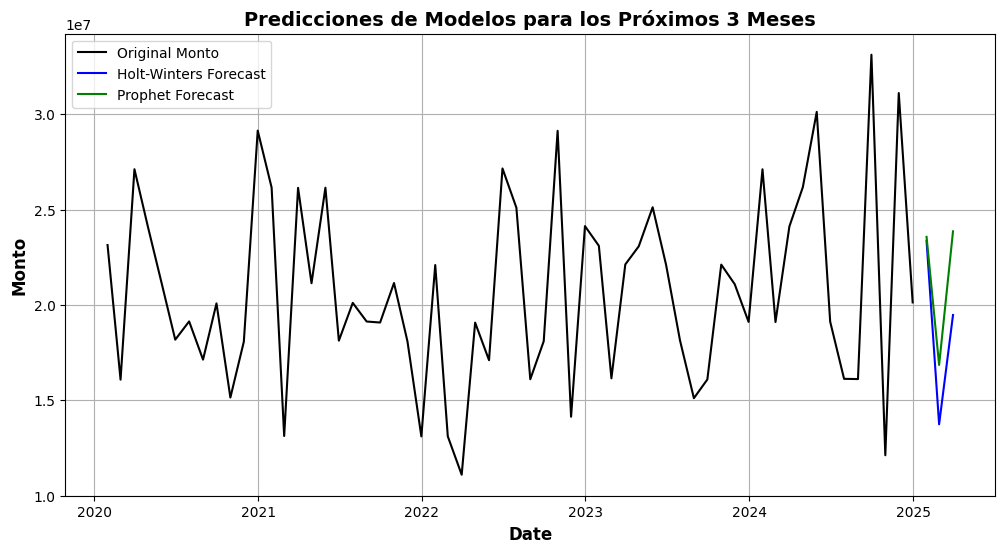

In [85]:
plt.figure(figsize=(12, 6), dpi=100)

sns.lineplot(data=df, x='Date', y='Monto', label='Original Monto', color='black')
sns.lineplot(data=future_df, x=future_df.index, y='Holt-Winters', label='Holt-Winters Forecast', color='blue')  
sns.lineplot(data=future_df, x=future_df.index, y='Prophet', label='Prophet Forecast', color='green')

plt.title('Predicciones de Modelos para los Próximos 3 Meses', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Monto', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True)

plt.show()

## CONCLUSIONES
Los resultados obtenidos en la tabla de predicciones muestran que, si bien tanto Holt–Winters como Prophet logran generar proyecciones razonables, el modelo Prophet se ajusta mejor a la tendencia observada en la serie temporal, reflejando de forma más coherente la variabilidad y comportamiento de los montos en los meses futuros.
Holt–Winters logra capturar algunos patrones de corto plazo, pero presenta mayores fluctuaciones que lo alejan del comportamiento esperado.

En este caso, Prophet se convierte en la opción más adecuada para el pronóstico, ya que sigue de manera más fiel la trayectoria de la serie en el horizonte de tres meses.

Recomiendo
Revisar la consistencia de los montos históricos.

Corregir o filtrar valores atípicos y entradas erróneas que afectan el modelado.

Estandarizar las fechas y periodicidad para evitar ruido en la serie.

Evaluar otros modelos que puedan tener mejor ajuste


